In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [2]:
!export HF_DATASETS_OFFLINE=1
!export TRANSFORMERS_OFFLINE=1

!export RESULTS_DIR=/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/results
!export FEATURE_DATASET_DIR=/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/feature_datasets
!export TRANSFORMERS_CACHE=/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads
!export HF_DATASETS_CACHE=/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads
!export HF_HOME=/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads


In [ ]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'

In [ ]:
import os
import time
import sys

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from einops import rearrange, repeat

from load import *
from activations.activation_all import get_full_activation_tensor
from activations.activation_metrics import get_activation_metrics
from activations.activation_subset import get_activation_subset
from activations.test import test_get_activation_metrics, test_get_activation_subset

In [4]:
model = load_model('pythia-19m')
feature_dataset = load_feature_dataset('counterfact.pyth.64.100')

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-19m into HookedTransformer


/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


## `get_activation_all`

In [5]:
activations = get_full_activation_tensor(model, feature_dataset, verbose=True)
assert activations.shape == (model.cfg.n_layers, model.cfg.d_mlp, 100, 64)  # layer, neuron, sequence, context

100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


In [6]:
activations.shape

torch.Size([6, 2048, 100, 64])

In [22]:
torch.histogramdd(rearrange(activations, 'l n b p -> (l n) (b p)'), bins=10).shape

RuntimeError: numel: integer multiplication overflow

In [17]:
activations.shape

torch.Size([6, 2048, 100, 64])

In [18]:
rearrange(activations, 'l n b p -> (l n) (b p)').shape

torch.Size([12288, 6400])

In [19]:
(12288 * 6400 * 4) / 2**30

0.29296875

In [21]:
(24 * 10_000 * 16 * 512 * 4) / 2**30

7.32421875

In [24]:
np_act = rearrange(activations.numpy(), 'l n b p -> (l n) (b p)')

(12288, 6400)

In [30]:
from functorch import vmap

In [ ]:
rearrange(activations, 'l n b p -> (l n) (b p)')

In [55]:
from functools import partial


In [56]:
bin_edges

tensor([-1.0000e+01, -9.8000e+00, -9.6000e+00, -9.4000e+00, -9.2000e+00,
        -9.0000e+00, -8.8000e+00, -8.6000e+00, -8.4000e+00, -8.2000e+00,
        -8.0000e+00, -7.8000e+00, -7.6000e+00, -7.4000e+00, -7.2000e+00,
        -7.0000e+00, -6.8000e+00, -6.6000e+00, -6.4000e+00, -6.2000e+00,
        -6.0000e+00, -5.8000e+00, -5.6000e+00, -5.4000e+00, -5.2000e+00,
        -5.0000e+00, -4.8000e+00, -4.6000e+00, -4.4000e+00, -4.2000e+00,
        -4.0000e+00, -3.8000e+00, -3.6000e+00, -3.4000e+00, -3.2000e+00,
        -3.0000e+00, -2.8000e+00, -2.6000e+00, -2.4000e+00, -2.2000e+00,
        -2.0000e+00, -1.8000e+00, -1.6000e+00, -1.4000e+00, -1.2000e+00,
        -1.0000e+00, -8.0000e-01, -6.0000e-01, -4.0000e-01, -2.0000e-01,
         3.8743e-07,  2.0000e-01,  4.0000e-01,  6.0000e-01,  8.0000e-01,
         1.0000e+00,  1.2000e+00,  1.4000e+00,  1.6000e+00,  1.8000e+00,
         2.0000e+00,  2.2000e+00,  2.4000e+00,  2.6000e+00,  2.8000e+00,
         3.0000e+00,  3.2000e+00,  3.4000e+00,  3.6

In [78]:
all_activations_by_neuron = rearrange(activations, 'l n b p -> (l n) (b p)')

n_bins = 100
bin_edges = torch.linspace(-1, 1, n_bins+1)
binned_histogram = partial(torch.histogram, bins=bin_edges)
vectorized_histogram = vmap(binned_histogram)
hist, _ = vectorized_histogram(all_activations_by_neuron)

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/functorch/_src/vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::histogram.bins_tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)


In [82]:
hist

tensor([[ 9.,  4.,  2.,  ...,  0.,  0.,  0.],
        [ 0.,  4.,  5.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  6.,  ...,  0.,  1.,  0.],
        ...,
        [12.,  8., 11.,  ...,  1.,  0.,  0.],
        [ 8.,  6.,  4.,  ...,  0.,  2.,  2.],
        [ 6.,  2.,  8.,  ...,  0.,  0.,  2.]])

In [75]:
neuron_histograms = rearrange(hist, '(l n) b -> l n b', l=model.cfg.n_layers, n=model.cfg.d_mlp, b=n_bins)

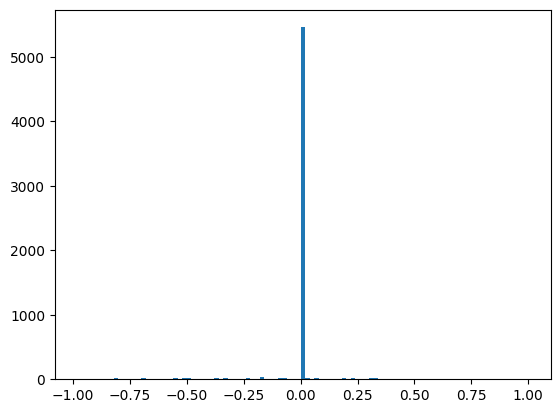

In [76]:
plt.hist(bin_edges[:-1], bin_edges[1:], weights=neuron_histograms[0, 0]);

In [77]:
neuron_histograms[0, 0].sum()

tensor(6116.)

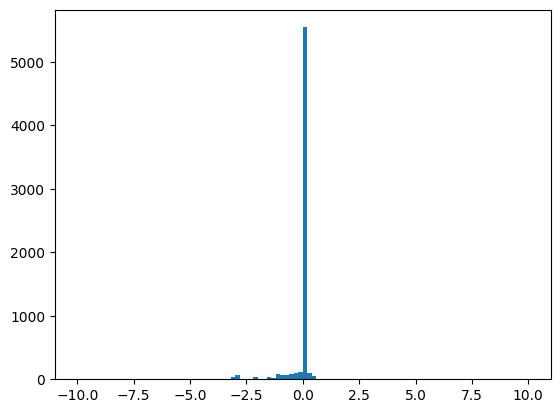

In [70]:
plt.hist(all_activations_by_neuron[0], bins=bin_edges);

In [73]:
all_activations_by_neuron[0]

tensor([ 0.0047, -1.5300,  0.3186,  ...,  0.0047,  0.0047,  0.0047])

In [44]:
h.shape

torch.Size([12288, 199])

In [45]:
b.shape

torch.Size([12288, 200])

In [46]:
b

tensor([[-10.0000,  -9.9000,  -9.8000,  ...,   9.7000,   9.8000,   9.9000],
        [-10.0000,  -9.9000,  -9.8000,  ...,   9.7000,   9.8000,   9.9000],
        [-10.0000,  -9.9000,  -9.8000,  ...,   9.7000,   9.8000,   9.9000],
        ...,
        [-10.0000,  -9.9000,  -9.8000,  ...,   9.7000,   9.8000,   9.9000],
        [-10.0000,  -9.9000,  -9.8000,  ...,   9.7000,   9.8000,   9.9000],
        [-10.0000,  -9.9000,  -9.8000,  ...,   9.7000,   9.8000,   9.9000]])

## `get_activation_metrics`

In [6]:
test_get_activation_metrics(model, feature_dataset)

  0%|          | 0/7 [00:00<?, ?it/s]

> /Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/activations/activation_metrics.py(33)get_activations_hist()
     31     import pdb
     32     pdb.set_trace()
---> 33     bin_counts_flat = torch.bincount(
     34         activations_flat.int(), minlength=n_layer*n_neuron*n_bin)
     35     assert len(bin_counts_flat) == n_layer*n_neuron*n_bin



## `get_activation_subset`

In [7]:
test_get_activation_subset(model, feature_dataset)

100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


get_activation_subset: 2.142, get_mlp_activations: 2.415
Subset keys correct: True
Subset values correct: True


In [8]:
# get function outputs
top_k = 10
n_bin = 30
hist_min = -.2
hist_max = 2

top_k_seqix, top_k_pos, bin_counts = get_activation_metrics(model, feature_dataset,
        top_k=top_k, n_bin=n_bin, hist_min=hist_min, hist_max=hist_max)
top_k_seqix.shape, top_k_pos.shape, bin_counts.shape

(torch.Size([6, 2048, 10]),
 torch.Size([6, 2048, 10]),
 torch.Size([6, 2048, 30]))

### Activation Histograms Visual Test

In [9]:
n_layer = model.cfg.n_layers
n_neuron = model.cfg.d_mlp

activations = get_activation_all(model, feature_dataset)
activations.shape

torch.Size([6, 2048, 100, 64])

In [10]:
for i in [.5, 1, 2, 3, 5, 10, 15, 25, 40, 100]:
    prop_captured = ((activations > i).sum() / activations.numel()).item()
    print(f'Proportion of activations greater than {i}: {prop_captured:.1E}')

Proportion of activations greater than 0.5: 1.3E-01
Proportion of activations greater than 1: 4.6E-02
Proportion of activations greater than 2: 5.9E-03
Proportion of activations greater than 3: 1.9E-03
Proportion of activations greater than 5: 1.0E-03
Proportion of activations greater than 10: 7.6E-04
Proportion of activations greater than 15: 4.8E-04
Proportion of activations greater than 25: 2.8E-04
Proportion of activations greater than 40: 1.0E-07
Proportion of activations greater than 100: 0.0E+00


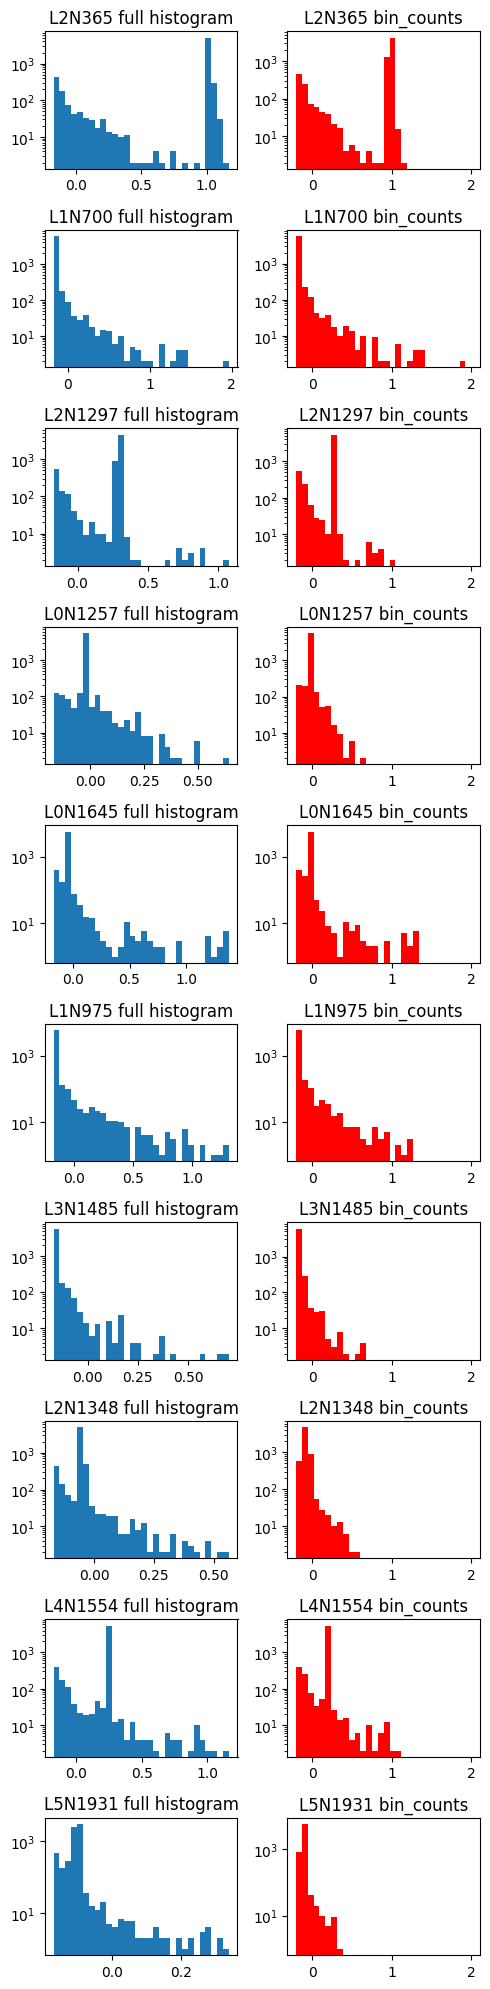

In [11]:
n = 10
fig, axes = plt.subplots(n, 2, figsize=(5, 2*n))

bin_edges = torch.linspace(hist_min, hist_max, n_bin+1)

for i in range(n):
    lix = np.random.randint(n_layer)
    nix = np.random.randint(n_neuron)

    axes[i,0].set_title(f'L{lix}N{nix} full histogram')
    axes[i,0].hist(activations[lix,nix,:,:].flatten(), bins=n_bin)
    axes[i,0].set_yscale('log')

    axes[i,1].set_title(f'L{lix}N{nix} bin_counts')
    axes[i,1].stairs(bin_counts[lix,nix,:], edges=bin_edges, color='r', fill=True)
    axes[i,1].set_yscale('log')

fig.tight_layout()

### Investigate Non-matching Top k Results

In [12]:
# verify indices match
# NOTE: due to repeated activations these do not match exactly
seq_len = len(feature_dataset[0]['tokens'])
v, i = torch.topk(rearrange(activations, 'a b c d -> a b (c d)'), top_k, dim=2, sorted=True)
top_k_seqix_compare = i // seq_len
top_k_pos_compare = i % seq_len
(top_k_pos == top_k_pos_compare).sum()/top_k_pos.numel(), (top_k_seqix == top_k_seqix_compare).sum()/top_k_pos.numel()

(tensor(0.9765), tensor(0.5492))

In [13]:
non_match = []
for i in range(top_k_pos.shape[0]):
    for j in range(top_k_pos.shape[1]):
        if not (top_k_pos[i,j] == top_k_pos_compare[i,j]).all():
            non_match.append((i,j))
            if len(non_match) == 10:
                break

for (i, j) in non_match:
    print(activations[i,j,:,:].flatten().sort(descending=True)[0][:top_k+1])

tensor([0.8360, 0.8360, 0.6687, 0.6567, 0.4638, 0.3722, 0.3695, 0.3617, 0.3617,
        0.3572, 0.3162])
tensor([0.9440, 0.7627, 0.7627, 0.6011, 0.6011, 0.6011, 0.5756, 0.5756, 0.5756,
        0.5108, 0.5108])
tensor([0.6727, 0.6727, 0.5643, 0.5643, 0.5417, 0.5417, 0.5101, 0.5101, 0.4678,
        0.4678, 0.4678])
tensor([1.0216, 1.0216, 1.0216, 1.0216, 1.0216, 1.0216, 0.8682, 0.8682, 0.8268,
        0.8268, 0.8268])
tensor([0.7804, 0.7804, 0.7804, 0.7804, 0.7804, 0.7804, 0.7804, 0.7804, 0.7543,
        0.7543, 0.6993])
tensor([0.7843, 0.7843, 0.7843, 0.7843, 0.7843, 0.7843, 0.7843, 0.7843, 0.6829,
        0.6829, 0.5344])
tensor([1.2178, 1.2178, 1.2178, 1.2178, 1.2178, 1.2178, 1.2178, 1.2178, 0.9728,
        0.7782, 0.7782])
tensor([0.8541, 0.8541, 0.6955, 0.6955, 0.6955, 0.6955, 0.6955, 0.6955, 0.6955,
        0.6955, 0.5570])
tensor([1.3993, 1.3993, 0.8901, 0.8901, 0.8322, 0.8322, 0.8322, 0.8322, 0.8322,
        0.8322, 0.8322])
tensor([0.7679, 0.7679, 0.6400, 0.6400, 0.6277, 0.6277,

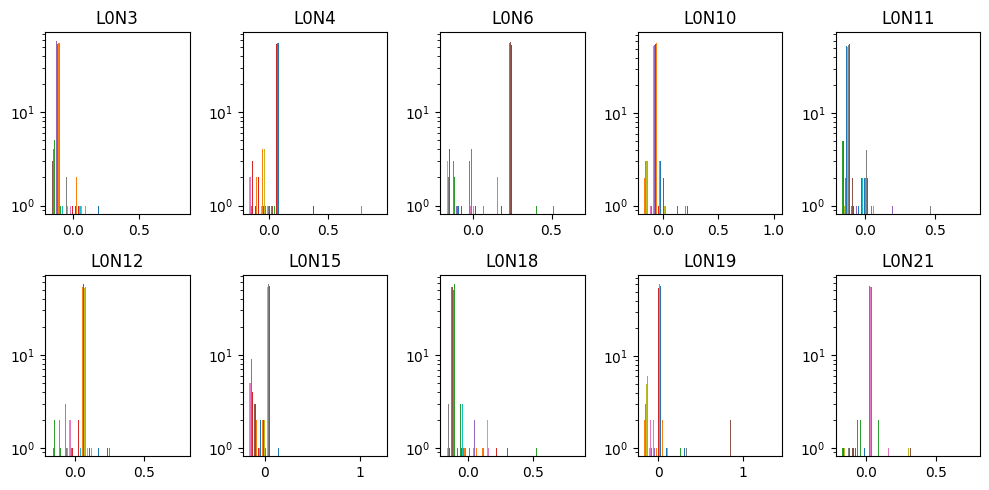

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for pos, ax in zip(non_match, axes.flatten()):
    ax.set_title(f'L{pos[0]}N{pos[1]}')
    ax.hist(activations[pos[0],pos[1]], bins=30)
    ax.set_yscale('log')

fig.tight_layout()

### Parameter tuning

In [15]:
feature_dataset_full = load_feature_dataset('counterfact.pyth.64.-1')

/Users/mtp/Projects/alignment/sparse-probing/sparprob/lib/python3.10/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [16]:
# TODO: run on gpu

def time_function(function, *args, **kwargs):
    start_time = time.perf_counter()
    out = function(*args, **kwargs)
    return out, time.perf_counter() - start_time

subset_size = 64
tuning_subset = feature_dataset_full.select(range(subset_size))
batch_sizes = [2, 4, 8, 16, 32]
times = []
for batch_size in batch_sizes:
    _, func_time = time_function(
        get_activation_metrics, model, tuning_subset,
        batch_size=batch_size, verbose=True)
    times.append(func_time)
    print(f'With batch size {batch_size} took {func_time:.3f} seconds, or {subset_size/func_time:.3f} examples per second')

100%|██████████| 32/32 [00:03<00:00,  9.85it/s]


With batch size 2 took 3.258 seconds, or 19.646 examples per second


100%|██████████| 16/16 [00:02<00:00,  6.25it/s]


With batch size 4 took 2.566 seconds, or 24.943 examples per second


100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


With batch size 8 took 2.297 seconds, or 27.867 examples per second


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


With batch size 16 took 2.170 seconds, or 29.497 examples per second


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

With batch size 32 took 2.241 seconds, or 28.553 examples per second


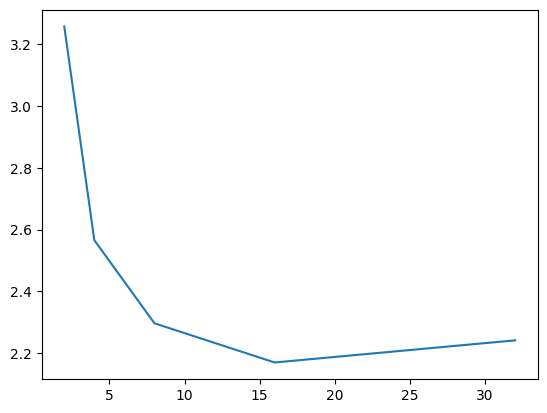

In [17]:
plt.plot(batch_sizes,times);

### Neuron Subset Saving and Loading

In [18]:
from activations.activation_subset import save_neuron_subset, load_neuron_subset

In [19]:
subset_size = 5
n_layer = 12
n_neuron = 3072
neuron_subset = [(np.random.randint(n_layer), np.random.randint(n_neuron)) for _ in range(subset_size)]
neuron_subset

[(5, 158), (10, 2469), (8, 1118), (5, 1010), (5, 2296)]

In [20]:
save_path_subset = '../tmp/neuron_subset.pt'
save_neuron_subset(neuron_subset, save_path_subset)
load_neuron_subset(save_path_subset)

[(5, 158), (10, 2469), (8, 1118), (5, 1010), (5, 2296)]